In [48]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import asyncio
import yaml
import os

In [49]:
async def get_frame(image_path):
    # Load the image from the specified path
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")
    return image

In [50]:
class Analytics:
    def __init__(self, model_path):
        # Load the YOLO model
        self.model = YOLO(model_path)

    async def analyze_frame(self, frame):
        # Perform object detection on the frame
        results = self.model(frame)[0]
        return results

    async def visualize_detections(self, frame, results):
        # Draw bounding boxes and labels on the frame
        annotated_frame = results.plot()
        return annotated_frame
    
    async def display_frame(self, frame):
        # Convert BGR to RGB for displaying with matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()


0: 384x640 10 persons, 2 sports balls, 1 tennis racket, 1 chair, 267.1ms
Speed: 1.3ms preprocess, 267.1ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


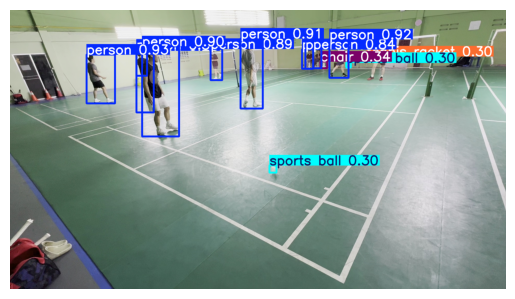

In [51]:
image_path = "/Volumes/PortableSSD/Two/Badminton-analytics/analytics/images/IMG_0211/frame_000575.jpg"

async def run_frame_analysis(image_path, model_path):
    analytics = Analytics(model_path)
    frame = await get_frame(image_path)
    results = await analytics.analyze_frame(frame)
    annotated_frame = await analytics.visualize_detections(frame, results)
    await analytics.display_frame(annotated_frame)

await run_frame_analysis(image_path, 'yolo26x.pt')


0: 384x640 1 Shuttlecock, 117.0ms
Speed: 1.1ms preprocess, 117.0ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


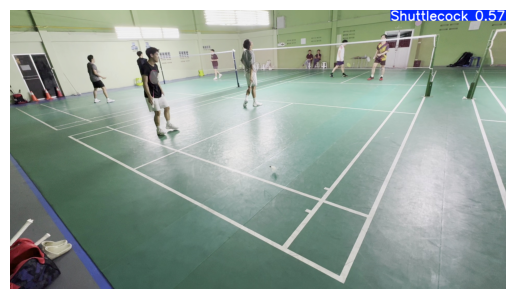

In [52]:
await run_frame_analysis(image_path, '/Volumes/PortableSSD/Two/Badminton-analytics/analytics/model/best_bad_stc.pt')

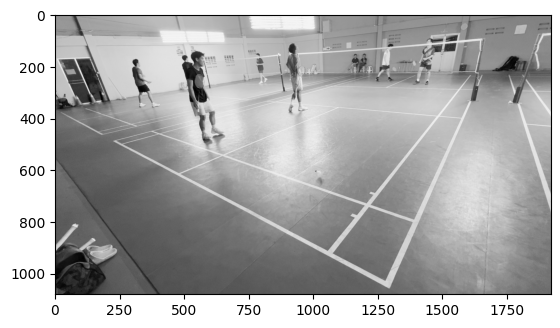

In [53]:
def img_to_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

img = await get_frame(image_path)

gray_image = img_to_gray(img)
plt.imshow(gray_image, cmap='gray')

In [54]:
# async def run_gray_frame_analysis(model_path):
#     analytics = Analytics(model_path)
#     gray_frame = img_to_gray(gray_image)
#     results = await analytics.analyze_frame(gray_frame)
#     annotated_frame = await analytics.visualize_detections(gray_frame, results)
#     await analytics.display_frame(annotated_frame)
    
# await run_gray_frame_analysis('yolo26l.pt')

In [55]:
def load_roi_config(config_path):
    """Load ROI coordinates from YAML config file"""
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found: {config_path}")
    
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    if 'roi_coordinates' not in config:
        raise ValueError("Invalid config file: 'roi_coordinates' not found")
    
    return config['roi_coordinates']

In [56]:
def draw_roi_on_image(image_path, roi_coordinates):
    """Draw ROI polygon on the image"""
    # Load image
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from: {image_path}")
    
    # Convert coordinates to numpy array for drawing
    points = np.array(roi_coordinates, dtype=np.int32)
    
    # Draw filled polygon with transparency
    overlay = image.copy()
    cv2.fillPoly(overlay, [points], (0, 255, 0))
    alpha = 0.3
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    
    # Draw polygon outline
    cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Draw points and numbers
    for i, point in enumerate(roi_coordinates):
        x, y = point
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
        cv2.putText(image, str(i+1), (x + 10, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    return image


In [57]:
def display_image(image):
    """Display image using matplotlib"""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

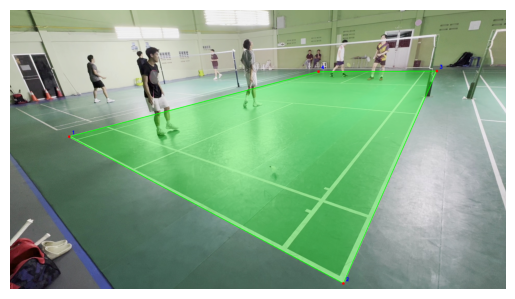

In [58]:
roi_path = '/Volumes/PortableSSD/Two/Badminton-analytics/analytics/src/config/roi/frame_000575_roi_config.yaml'
draw_roi = draw_roi_on_image(image_path, load_roi_config(roi_path))
display_image(draw_roi)